In [80]:
from helpers import *

In [81]:
import statsmodels.api as stats
# results = stats.OLS(y, X).fit()
# results.summary()

In [82]:
spy = stock_prices('SPY')

In [83]:
df = stock_prices('ADBE')


In [53]:
spy_smooth = spy.pct_change().adj_close#.rolling(window=40, win_type='gaussian', center=True).mean(std=20)

In [54]:
pct_ch = df.pct_change()
adj_close_deltas = pct_ch.adj_close

In [55]:
sm_adj_close_dt = adj_close_deltas#.rolling(window=40, win_type='gaussian', center=True).mean(std=20)

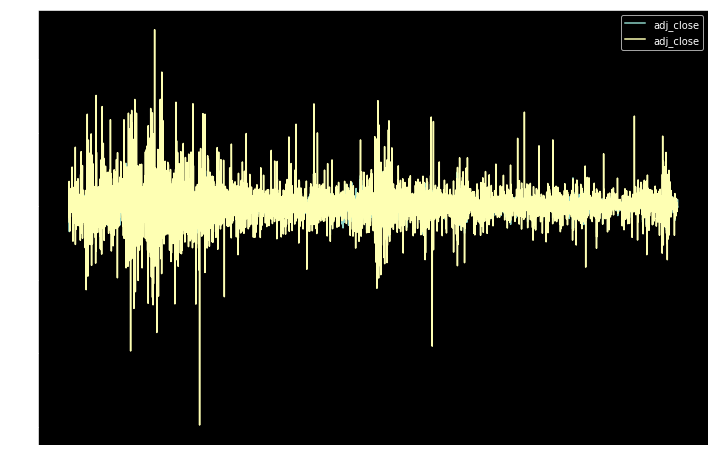

In [56]:

pd.concat([spy_smooth,sm_adj_close_dt], axis=1).plot(figsize=(12,8))


In [57]:
diff = spy_smooth - sm_adj_close_dt

In [58]:
X = left_windows(diff.dropna(),30)

In [59]:
X.head()

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
1998-02-02,-0.003867,-0.003847,-0.003826,-0.049589,0.017452,-0.017827,-0.012373,0.010132,0.010112,0.010092,...,0.005028,0.007362,0.007420,0.007479,0.010103,-0.005939,0.013605,-0.022476,0.006549,0.006520
1998-02-03,-0.003847,-0.003826,-0.049589,0.017452,-0.017827,-0.012373,0.010132,0.010112,0.010092,0.026246,...,0.007362,0.007420,0.007479,0.010103,-0.005939,0.013605,-0.022476,0.006549,0.006520,0.006491
1998-02-04,-0.003826,-0.049589,0.017452,-0.017827,-0.012373,0.010132,0.010112,0.010092,0.026246,0.038616,...,0.007420,0.007479,0.010103,-0.005939,0.013605,-0.022476,0.006549,0.006520,0.006491,0.009321
1998-02-05,-0.049589,0.017452,-0.017827,-0.012373,0.010132,0.010112,0.010092,0.026246,0.038616,-0.017838,...,0.007479,0.010103,-0.005939,0.013605,-0.022476,0.006549,0.006520,0.006491,0.009321,-0.025786
1998-02-06,0.017452,-0.017827,-0.012373,0.010132,0.010112,0.010092,0.026246,0.038616,-0.017838,0.014316,...,0.010103,-0.005939,0.013605,-0.022476,0.006549,0.006520,0.006491,0.009321,-0.025786,-0.005459


In [60]:
X['y'] = pct_ch.adj_close

In [61]:
y = X.pop('y')

In [62]:
results = stats.OLS(y.values,X.values).fit()

In [63]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.628
Date:                Fri, 26 Apr 2019   Prob (F-statistic):             0.0166
Time:                        22:39:54   Log-Likelihood:                 18665.
No. Observations:                7745   AIC:                        -3.727e+04
Df Residuals:                    7715   BIC:                        -3.706e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0125      0.013     -0.931      0.352      -0.039       0.014
x2            -0.0196      0.013     -1.457      0.145      -0.046       0.007
x3             0.0039      0.013      0.287      0.774      -0.022       0.030
x4             0.0141      0.013      1.052      0.293      -0.012       0.040
x5             0.0200      0.013      1.484      0.138      -0.006       0.046
x6             0.0008      0.013      0.059      0.953      -0.026       0.027
x7            -0.0055      0.013     -0.408      0.683      -0.032       0.021
x8             0.0224      0.013      1.665      0.096      -0.004       0.049
x9            -0.0035      0.013     -0.262      0.793      -0.030       0.023
x10           -0.0198      0.013     -1.475      0.140      -0.046       0.007
x11            0.0078      0.013      0.582      0.561      -0.019       0.034
x12            0.0018      0.013      0.137      0.891      -0.025       0.028
x13            0.0126      0.013      0.938      0.348      -0.014       0.039
x14           -0.0014      0.013     -0.107      0.915      -0.028       0.025
x15           -0.0069      0.013     -0.516      0.606      -0.033       0.019
x16            0.0405      0.013      3.009      0.003       0.014       0.067
x17            0.0305      0.013      2.267      0.023       0.004       0.057
x18           -0.0122      0.013     -0.904      0.366      -0.039       0.014
x19            0.0024      0.013      0.178      0.859      -0.024       0.029
x20           -0.0017      0.013     -0.128      0.898      -0.028       0.025
x21            0.0020      0.013      0.147      0.883      -0.024       0.028
x22            0.0126      0.013      0.934      0.350      -0.014       0.039
x23           -0.0361      0.013     -2.682      0.007      -0.062      -0.010
x24            0.0203      0.013      1.509      0.131      -0.006       0.047
x25            0.0008      0.013      0.056      0.955      -0.026       0.027
x26           -0.0215      0.013     -1.596      0.111      -0.048       0.005
x27            0.0185      0.013      1.376      0.169      -0.008       0.045
x28            0.0095      0.013      0.706      0.480      -0.017       0.036
x29           -0.0076      0.013     -0.565      0.572      -0.034       0.019
x30            0.0167      0.013      1.242      0.214      -0.010       0.043
==============================================================================
Omnibus:                     1863.738   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94525.218
Skew:                           0.267   Prob(JB):                         0.00
Kurtosis:                      20.106   Cond. No.                         1.19
==============================================================================

W

In [64]:
from sklearn.decomposition import PCA


In [66]:
pca = PCA(n_components=2)

In [71]:
X['y'] = y
pXi = X[X['y'] > 0].index
nXi = X[X['y'] < 0].index
X.pop('y')

Xp = pd.DataFrame(pca.fit_transform(X),index = X.index)


In [77]:
Xp.head()

,0,1
1998-02-02,-0.001671,0.018814
1998-02-03,0.010521,-0.006225
1998-02-04,-0.016442,-0.007879
1998-02-05,0.021321,0.019903
1998-02-06,0.000412,-0.017026


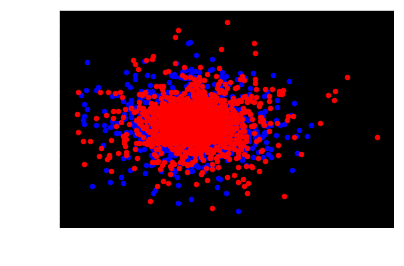

In [79]:
ax = Xp.loc[pXi].plot.scatter(x=0,y=1,c='b')
Xp.loc[nXi].plot.scatter(x=0,y=1,c='r',ax=ax)